In [1]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Tue Aug 23 17:46:33 2022
Driver Version                            : 510.47.03
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:A1:00.0
    Product Name                          : NVIDIA A100-PCIE-40GB
    Product Brand                         : NVIDIA
    Product Architecture                  : Ampere
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : Enabled
        Pending                           : Enabled
    MIG Device
        Index                             : 0
        GPU Instance ID                   : 6
        Compute Instance ID               : 0
        Device Attributes
            Shared
                Multiprocessor count      : 28
                Copy Engine coun

In [56]:
import os.path as osp

import torch
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset

import torch_geometric.transforms as T
from torch_geometric.nn import MaskLabel, TransformerConv
from torch_geometric.utils import index_to_mask

In [57]:
!pwd

/home/jovyan/work/semi-supervised-tests/Jupyter


In [58]:
root = "/home/jovyan/work/semi-supervised-tests/Jupyter/data/OGB"
dataset = PygNodePropPredDataset('ogbn-arxiv', root, T.ToUndirected())

In [59]:
class UniMP(torch.nn.Module):   #UniMP stands for Unified Message Passing
    def __init__(self, in_channels, num_classes, hidden_channels, num_layers,
                 heads, dropout=0.3):
        super().__init__()

        self.label_emb = MaskLabel(num_classes, in_channels)

        self.convs = torch.nn.ModuleList()  # initialize self.convs
        self.norms = torch.nn.ModuleList()  # initialize self.norms
        for i in range(1, num_layers + 1):
            if i < num_layers:
                out_channels = hidden_channels // heads #what is a head?
                concat = True   #what does concat do?
            else:
                out_channels = num_classes
                concat = False
            conv = TransformerConv(in_channels, out_channels, heads,
                                   concat=concat, beta=True, dropout=dropout)
            self.convs.append(conv)
            in_channels = hidden_channels

            if i < num_layers:
                self.norms.append(torch.nn.LayerNorm(hidden_channels))
                
    def forward(self, x, y, edge_index, label_mask):
        x = self.label_emb(x, y, label_mask)  #mask some of the input labels
        for conv, norm in zip(self.convs, self.norms):
            x = norm(conv(x, edge_index)).relu()
        # conv -> norm -> ReLu -> conv -> norm -> Relu -> ... -> out
        return self.convs[-1](x, edge_index)

## Questions:  

### 2. What does emb stand for?  
Embedding

### 3. What are normalization layers?  what do they do and why do we need them?
https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html  
Normalization? but why?

### 3.1 What are heads?  

### 4. What does concat do?  
If set to False, the multi-head attentions are averaged instead of concatenated. (default: True)  

### 4.1 What are attentions?  

### 7. Why a separate if statement for self.norms?


### 8. What does each parameter mean in this function?  
x: input?  
y: output?  
edge_index: how the graph is connected  
label_mask: 

### 8.1 What does the first line do?  

In [60]:
"""
def forward(self, x: Tensor, y: Tensor, mask: Tensor) -> Tensor:  
        """"""  
        if self.method == "concat":  
            out = x.new_zeros(y.size(0), self.emb.weight.size(-1))  
            out[mask] = self.emb(y[mask])  
            return torch.cat([x, out], dim=-1)  
        else:  
            x = torch.clone(x)  
            x[mask] += self.emb(y[mask])  
            return x
"""

'\ndef forward(self, x: Tensor, y: Tensor, mask: Tensor) -> Tensor:  \n          \n        if self.method == "concat":  \n            out = x.new_zeros(y.size(0), self.emb.weight.size(-1))  \n            out[mask] = self.emb(y[mask])  \n            return torch.cat([x, out], dim=-1)  \n        else:  \n            x = torch.clone(x)  \n            x[mask] += self.emb(y[mask])  \n            return x\n'

I assume this applies the mask to the inputs x but why does this process involve y?  

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
data.y = data.y.view(-1)
model = UniMP(dataset.num_features, dataset.num_classes, hidden_channels=64,
              num_layers=3, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
 
split_idx = dataset.get_idx_split()   # train/val/test split
train_mask = index_to_mask(split_idx['train'], size=data.num_nodes)
val_mask = index_to_mask(split_idx['valid'], size=data.num_nodes)
test_mask = index_to_mask(split_idx['test'], size=data.num_nodes)

### 10. What is weight_decay?  
L2 penalty  
https://swamp-father-f58.notion.site/2-3-Lecture-Dealing-with-Overfitting-f1a77a6d12f445698e4d8cb340300d88

### 12. What does the mask do?  
They mask some of the labels, preventing the nodes from accessing those labels during training/validation/testing



In [62]:
def train(label_rate=0.65):  # How many labels to use for propagation.
    model.train()

    propagation_mask = MaskLabel.ratio_mask(train_mask, ratio=label_rate)
    # Randomly modifies mask by setting a certain ratio (label_rate) of True entries to False
    supervision_mask = train_mask ^ propagation_mask  # Exclusive or: Sets each bit to 1 if only one of two bits is 1
#     print("train_mask:", train_mask)
#     print("propagation_mask:", propagation_mask)
#     print("supervision_mask:", supervision_mask)

    # how to implement mini-batch gradient descent here? Right now going through the data set all at once, taking up too much memory
    optimizer.zero_grad()
    out = model(data.x, data.y, data.edge_index, propagation_mask)  #forward is called
    loss = F.cross_entropy(out[supervision_mask], data.y[supervision_mask])
    loss.backward()
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()

    # evaluation
    propagation_mask = train_mask  #no masked nodes while testing
    out = model(data.x, data.y, data.edge_index, propagation_mask)  # forward is called
    pred = out[val_mask].argmax(dim=-1)  #indices of maximum values across the last dimension
    val_acc = int((pred == data.y[val_mask]).sum()) / pred.size(0)  # Validation accuracy
#     print("out:", out)
#     print("out dim:", out.size())
#     print("out[val_mask] dim:", out[val_mask].size())
#     print("out[test_mask] size:", out[test_mask].size())
#     print("out[train_mask] size:", out[train_mask].size())
#     print("out summed over dimension 1", torch.sum(out, dim=1))
# #     print("out[val_mask]:", out[val_mask])
#     print("eval pred:", pred)
#     print("labels:", data.y[val_mask])
#     print("pred size:",pred.size())
#     print("data.y[val_mask] size:", data.y[val_mask].size())

    # testing
    propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[test_mask].argmax(dim=-1)
    test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)
#     print("test pred", pred)
    
#     print("labels:", data.y[test_mask])

    return val_acc, test_acc

# Summary
out is a torch tensor of dimension [169343, 40].  
out[val_mask] is a torch tensor of dimension [29799, 40].  
This ratio 0.1759683 should be one of the three numbers in the train/val/test split.  
This is confirmed by   
out[val_mask] dim: torch.Size([29799, 40])  
out[test_mask] size: torch.Size([48603, 40])  
out[train_mask] size: torch.Size([90941, 40])  
(The three numbers add up to out.size(0))  

(during evaluation) pred is a torch tensor of dimension [29799]  
It is the indices of maximum values across the second dimension of out[val_mask]

I am assuming each of the 40 numbers is some sort of probability of classifying a data point into a certain category. **But they are negative and do not sum to 1. How to interpret these?**
This way, pred then consists of the predictions of the model (which category does a certain data point fall into)

### 13. What is propagation_mask?  
decides which nodes to use for message passing
### 13.1 What is supervision_mask?  
decides which nodes to use for verifying predictions  
(propagation + supervision = training)

## 14. What is argmax(dim=-1)
Returns the indices of the maximum values of a tensor across a dimension.
https://pytorch.org/docs/stable/generated/torch.argmax.html

finding the argument that gives the max value across the last dimension, which is 40.  
But now what does the 40 represent?  
40 categories

In [97]:
def reset_params(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()

In [82]:
reset_params(model)

label_rate = 0.55
num_epochs = 300
loss_lst, val_acc_lst, test_acc_lst = [], [], []

for epoch in range(1, num_epochs+1):
    loss = train(label_rate = label_rate)
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
    loss_lst.append(loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)

Epoch: 001, Loss: 2.5047, Val: 0.4969, Test: 0.4625
Epoch: 002, Loss: 1.7416, Val: 0.5549, Test: 0.5309
Epoch: 003, Loss: 1.5370, Val: 0.5991, Test: 0.5861
Epoch: 004, Loss: 1.4237, Val: 0.6197, Test: 0.6118
Epoch: 005, Loss: 1.3226, Val: 0.6444, Test: 0.6386
Epoch: 006, Loss: 1.2427, Val: 0.6611, Test: 0.6536
Epoch: 007, Loss: 1.2156, Val: 0.6663, Test: 0.6530
Epoch: 008, Loss: 1.1755, Val: 0.6601, Test: 0.6425
Epoch: 009, Loss: 1.1755, Val: 0.6619, Test: 0.6443
Epoch: 010, Loss: 1.1485, Val: 0.6748, Test: 0.6621
Epoch: 011, Loss: 1.1181, Val: 0.6928, Test: 0.6819
Epoch: 012, Loss: 1.0841, Val: 0.6985, Test: 0.6942
Epoch: 013, Loss: 1.0716, Val: 0.6985, Test: 0.6958
Epoch: 014, Loss: 1.0584, Val: 0.6973, Test: 0.6932
Epoch: 015, Loss: 1.0497, Val: 0.6994, Test: 0.6939
Epoch: 016, Loss: 1.0430, Val: 0.7015, Test: 0.6959
Epoch: 017, Loss: 1.0301, Val: 0.7044, Test: 0.6993
Epoch: 018, Loss: 1.0162, Val: 0.7078, Test: 0.7033
Epoch: 019, Loss: 1.0056, Val: 0.7087, Test: 0.7053
Epoch: 020, 

In [83]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

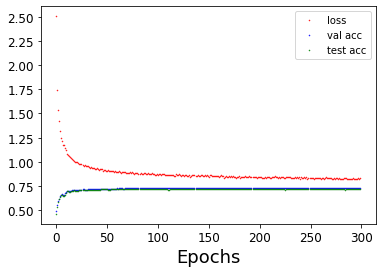

In [84]:
marker_size = 1
plt.plot(loss_lst, "r.", markersize=marker_size, label="loss")
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

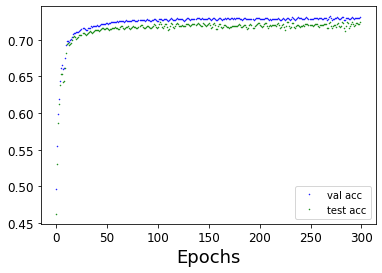

In [85]:
marker_size = 1
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

In [86]:
print("best val epoch:", torch.Tensor(val_acc_lst).argmax())
print("best test epoch:", torch.Tensor(test_acc_lst).argmax())
print("best val acc:", torch.Tensor(val_acc_lst).max())
print("best test acc:", torch.Tensor(test_acc_lst).max())

best val epoch: tensor(269)
best test epoch: tensor(269)
best val acc: tensor(0.7322)
best test acc: tensor(0.7248)


# Optimize label_rate

In [90]:
import numpy as np
label_rate_arr = np.linspace(0.0, 1.0, num=21)

In [110]:
def optimization_loop(label_rate):
    reset_params(model)
    num_epochs = 300
    loss_lst, val_acc_lst, test_acc_lst = [], [], []

    print(f'Label_rate: {label_rate}')
    for epoch in range(1, num_epochs+1):
        loss = train(label_rate = label_rate)
        val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, '
              f'Test: {test_acc:.4f}')
        loss_lst.append(loss)
        val_acc_lst.append(val_acc)
        test_acc_lst.append(test_acc)
    return loss_lst, val_acc_lst, test_acc_lst

In [ ]:
best_val_acc_lst, best_val_epoch_lst, best_test_acc_lst, best_test_epoch_lst = [], [], [], []
for lr in label_rate_arr:
    print(lr)
    lost_lst, val_acc_lst, test_acc_lst = optimization_loop(lr)
    
    best_val_epoch_lst.append(torch.Tensor(val_acc_lst).argmax())
    best_val_acc_lst.append(torch.Tensor(val_acc_lst).max())
    best_test_epoch_lst.append(torch.Tensor(test_acc_lst).argmax())
    best_test_acc_lst.append(torch.Tensor(test_acc_lst).max())

0.0
Label_rate: 0.0
Epoch: 001, Loss: 0.8324, Val: 0.2086, Test: 0.1214
Epoch: 002, Loss: 0.8330, Val: 0.2100, Test: 0.1232
Epoch: 003, Loss: 0.8325, Val: 0.2086, Test: 0.1211
Epoch: 004, Loss: 0.8305, Val: 0.2085, Test: 0.1211
Epoch: 005, Loss: 0.8321, Val: 0.2059, Test: 0.1215
Epoch: 006, Loss: 0.8314, Val: 0.2088, Test: 0.1212
Epoch: 007, Loss: 0.8320, Val: 0.2118, Test: 0.1248
Epoch: 008, Loss: 0.8301, Val: 0.2057, Test: 0.1198
Epoch: 009, Loss: 0.8317, Val: 0.2148, Test: 0.1279
Epoch: 010, Loss: 0.8316, Val: 0.2049, Test: 0.1206
Epoch: 011, Loss: 0.8304, Val: 0.2136, Test: 0.1258
Epoch: 012, Loss: 0.8304, Val: 0.2095, Test: 0.1241
Epoch: 013, Loss: 0.8318, Val: 0.2092, Test: 0.1218
Epoch: 014, Loss: 0.8312, Val: 0.2114, Test: 0.1258
Epoch: 015, Loss: 0.8317, Val: 0.2025, Test: 0.1176
Epoch: 016, Loss: 0.8308, Val: 0.2122, Test: 0.1241
Epoch: 017, Loss: 0.8294, Val: 0.2043, Test: 0.1189
Epoch: 018, Loss: 0.8306, Val: 0.2099, Test: 0.1217
Epoch: 019, Loss: 0.8335, Val: 0.2027, Test:

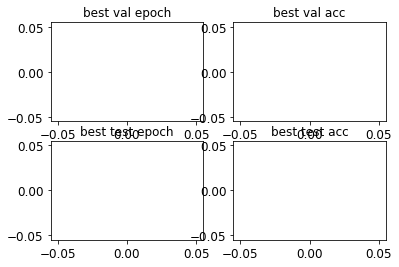

In [105]:


marker_size = 3
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(best_val_epoch_lst, "b.", markersize=marker_size)
axs[0, 0].set_title("best val epoch")


axs[0, 1].plot(best_val_acc_lst, "b.",markersize=marker_size)
axs[0, 1].set_title("best val acc")

axs[1, 0].plot(best_test_epoch_lst, "b.",markersize=marker_size)
axs[1, 0].set_title("best test epoch")

axs[1, 1].plot(best_test_acc_lst, "b.",markersize=marker_size)
axs[1, 1].set_title("best test acc")

plt.show()

## Try to plot the ROC curve
y-axis: true positive rate = test_acc  
x-axis: false positive rate

In [88]:
from sklearn.metrics import roc_curve

In [89]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

NameError: name 'y_train_5' is not defined

## Question:
sklearn.metrics.roc_curve and other functions built on top of it (such as https://pytorch.org/ignite/generated/ignite.contrib.metrics.RocCurve.html) only work for binary classification tasks. How to modify it/this code to use those functions?